In [2]:
import numpy as np
import matplotlib.pyplot as plt

def sqrwv(x, la, lb):
    lh = np.abs(la - lb) / 2.
    lq = lh / 2
    left = la + lq
    right = la + lh
    w = np.where(np.logical_and(x > left, x < right), 1, 0)

    return w

def gauss(Q, Ld, Lc=None):
    """
    GAUSS  Gaussian function (cutoff allowed)

    Inputs:
    Q : array_like
        A grid over which to compute the function
    Ld : float
        Decorrelation length of the Gaussian function
    Lc : float, optional
        Cutoff value of correlations

    Returns:
    Q : ndarray
        Gaussian function values computed over the grid Q
    """

    if Lc is None:
        Q = np.exp(-0.5 * (Q / Ld) ** 2)  # Gaussian
    else:
        Q = (np.abs(Q) < Lc) * np.exp(-0.5 * (Q / Ld) ** 2)  # Gaussian with cutoff

    return Q


def gcorr(func, Lx, Ld, J, opt, Lc=None):
    """
    Construct a correlation matrix on a periodic domain.

    Parameters:
    func : str
        Representation function, e.g., 'gauss', 'foar'.
    Lx : float
        Size of the domain.
    Ld : float
        (De)correlation length.
    J : int
        Number of grid points.
    opt : int
        Options for plotting:
        0 = no plots produced
        1 = contour plot of Q
    Lc : float, optional
        Optional argument referring to cutoff length; in this case, Q
        will not be positive semi-definite.

    Returns:
    Q : ndarray
        Correlation matrix on the grid.
    D : ndarray
        Eigenvalues of Q (should all be >=0, unless Lc has been specified).
    """

    Q = np.zeros((J, J))
    Ix = np.arange(-J//2 + 1, J//2 + 1)
    Iy = np.arange(-J//2 + 1, J//2 + 1)
    I1, I2 = np.meshgrid(Ix, Iy)
    Idiff = I1 - I2
    Dist = np.mod(Idiff, J)
    Q = Lx * np.sin(np.pi * Dist / J)

    if Lc is not None:
        Q = (np.abs(Q) < Lc) * Q  # Cutoff by force; resulting Q won't be positive

    if func == 'gauss':
        Q = gauss(Q, Ld, Lc)

    V, D = np.linalg.eig(Q)

    if opt == 1:
        # plt.figure(3)
        # plt.clf()
        # plt.figure(2)
        # plt.clf()
        plt.figure(3)
        plt.pcolor(Q)
        plt.colorbar(cmap='viridis')
        plt.title('Contour Plot of Q')
        
        plt.figure(2)
        plt.subplot(2, 1, 1)
        plt.plot(Q[:, J//2])
        plt.subplot(2, 1, 2)
        plt.plot(Q[:, J-1])
        plt.title('Q at Indices J/2 and J')

        D = np.sort(D)
        D = D[::-1]
        plt.figure(1)
        plt.plot(D)
        plt.title('Eigenvalues of Q')

    return Q, D

def gauss(Q, Ld, Lc=None):
    if Lc is None:
        Q = np.exp(-0.5 * (Q / Ld) ** 2)  # Gaussian
    else:
        Q = (np.abs(Q) < Lc) * np.exp(-0.5 * (Q / Ld) ** 2)  # Gaussian with cutoff

    return Q



Number of gridpoints :  360

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,
31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,
61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,
91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,
121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,
151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,
181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,
211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,
241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,
271,272,273,274,275,276

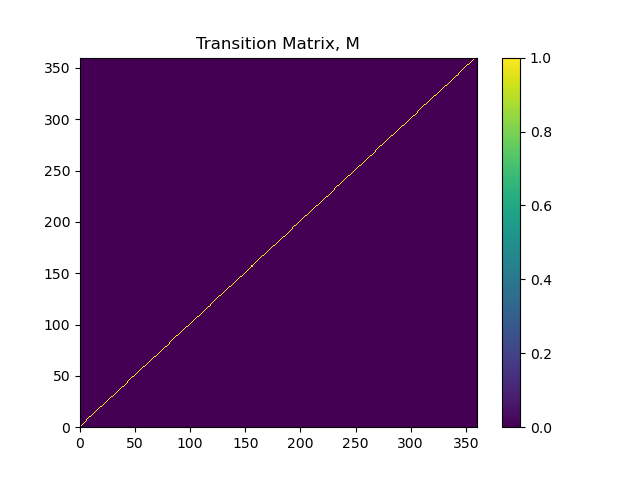

In [3]:
np.random.seed(1)  # Set random seed for reproducibility

# spatial domain (1D)
La = -180  # lower bound
Lb = 180   # upper bound
dx = 1.0   # delta x
x = np.arange(La, Lb, dx)  # x axis
N = len(x)  # number of gridpoints

print('Number of gridpoints : ',N)


# advection parameters
dt = 1.0             # time step (1 s)
u = 1.0              # advection speed in m/s
C = u * dt / (2. * dx)  # coefficient
nStep = 300          # length of integration (s)

# construct system noise covariance (assume no noise for now)
var_true = 0            # true system variance
Ld = 0.25 * np.abs(La)  # correlation length
Rt, De = gcorr('gauss',Lb-La,Ld,N,0) # construct the true error correlation
Qt = var_true*Rt # true error covariance

#==========================================================================
# generate truth xt~N(mu,Qt), xf~N(xt,Q)
np.random.seed(1)


# mean of initial true state is a square wave
mu = sqrwv (x, La, Lb )
xt= np.random.multivariate_normal(mu,Qt)  # initial true state

#==========================================================================
# assume noise of the forecast model initial states
varQ=0.5;                         # model error variance  
Q=varQ*Rt;                        # model error covariance  
xf=np.random.multivariate_normal(xt,Q)   # initial forecast state 
Pf=Q;                             # initial forecast error covariance
#==========================================================================

# add model error if you want
add_model_error = 0
if add_model_error == 0:
    Q = 0
else:
    Q = varQ*Rt


#==========================================================================
# set up observations
nobs=20                          # number of obs in the spatial domain
dobs=5                           # get obs every dobs time step
var_y=0.01                       # obs error variance
y_count=0                        # initial count for obs
y_save=np.zeros([nobs, nStep/dobs]);   # obs taken every 5 time step 
R=var_y*np.eye(nobs);                # obs error covariance

# do analaysis?
analysis = 1

# initialize matrices to be saved
xt_save=np.zeros([N,nStep]);           # true state
xf_save=np.zeros([N,nStep]);           # forecast state
Pf_save=np.zeros([N,N,nStep]);         # forecast error covariance
xa_save=np.zeros([N,nStep]);           # analysis state
Pa_save=np.zeros([N,N,nStep]);         # analysis error covariance


# dynamic model matrix
M = np.zeros((N, N))

# first grid point (periodic domain)
M[0, N - 1] = C + 2 * C ** 2
M[0, 0] = 1 - 4 * C ** 2
M[0, 1] = 2 * C ** 2 - C

# central grid points
for i in range(1, N - 1):
    M[i, i - 1] = C + 2 * C ** 2
    M[i, i] = 1 - 4 * C ** 2
    M[i, i + 1] = 2 * C ** 2 - C

# last grid point
M[N - 1, N - 2] = C + 2 * C ** 2
M[N - 1, N - 1] = 1 - 4 * C ** 2
M[N - 1, 0] = 2 * C ** 2 - C

#==========================================================================    
# set initial analysis to be the forecast states
xa=xf
Pa=Pf

# construct observation operator
H = np.zeros([nobs,N])
col = np.arange(4,360,360/20) - 1
for i in range(0,nobs):
    H[i,col[i]]=1


# construct identity matrix (MxN)
I = np.eye(N)

#==========================================================================
# MAIN LOOP (time loop)
xa=xf.copy()
for istep in range(nStep):

    if istep % 15 !=0:
        print(istep, end=',')
    else:
        print('')

    # true state time update
    xt=np.random.multivariate_normal(M@xt,Qt)
    xt_save[:,istep]=xt
    
    # forecast state time update
    xf=M@xa
    xf_save[:,istep]=xf

    # forecast error covariance time update
    Pf = M @ Pa @ M.T + Q
    Pf_save[:,:,istep] = Pf

    #=====================================
    # if there obs?
    if (istep+1) % dobs == 0:
        #get obs
        yt = H @ xt
        #add noise
        y = yt + np.sqrt(var_y) * np.random.normal(nobs,1)
        #obs counter
        y_count = y_count+1
        y_save[:,y_count] = y
    #=====================================
        if analysis == 1:
            # compyte Kalman Gain
            K = Pf @ H.T @ np.linalg.inv(H@Pf@H.T + R)
            # analysis state update
            xa = xf + K@ (y - H@xf)
            #analysis error covariance update
            Pa = (I - K@H) @ Pf @ (I-K@H).T + K@R@K.T
        else:
            # without observations, xf is equal to xa
            xa=xf
            Pa=Pf
    else:
        xa=xf
        Pa=Pf

    xa_save[:,istep] = xa
    Pa_save[:,:,istep] = Pa
    
    Var_save[:,istep]
            

array([  4.,  22.,  40.,  58.,  76.,  94., 112., 130., 148., 166., 184.,
       202., 220., 238., 256., 274., 292., 310., 328., 346.])

## Movie

In [ ]:
!pip install ipympl


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

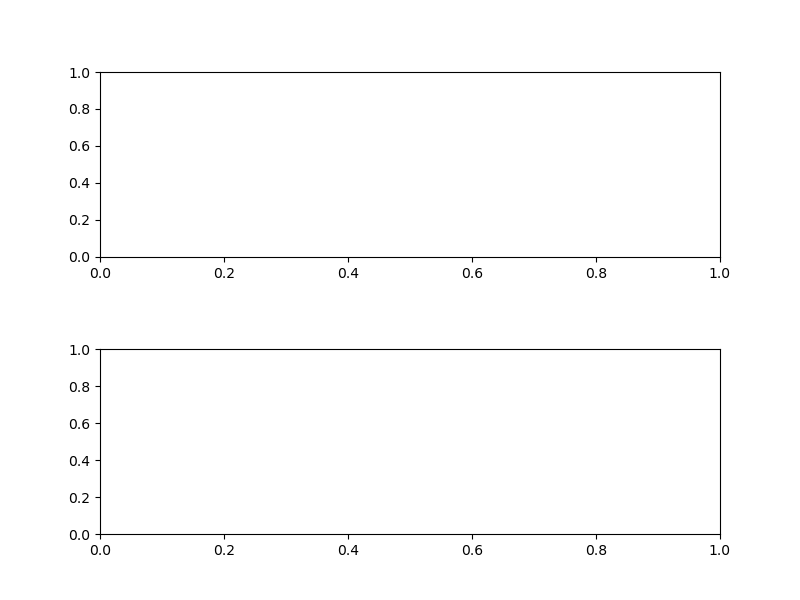

In [4]:
%matplotlib ipympl

from matplotlib.animation import FuncAnimation

Movme = []

fig, axs = plt.subplots(2, 1, figsize=(8, 6))

def update_plot(istep):
    axs[0].clear()
    axs[1].clear()
    
    axs[0].plot(xt_save[:, istep], 'k-', linewidth=2)
    axs[0].set_ylabel('State', fontsize=14)
    axs[0].set_ylim([-2, 2])
    axs[0].set_xlim([0, 360])
    axs[0].set_xticks(np.arange(0, 361, 60))
    axs[0].set_xticklabels(['-180', '-120', '-60', '0', '60', '120', '180'])
    axs[0].set_xlabel('Position', fontsize=14)
    axs[0].tick_params(axis='both', which='major', labelsize=14)
    axs[0].grid(True)
    axs[0].set_title(f'True State for Time # {istep}', fontsize=16)
    
    axs[1].plot(xf_save[:, istep], color=[0, 0.5, 0], linewidth=2)
    axs[1].set_ylabel('State', fontsize=14)
    axs[1].set_ylim([-2, 2])
    axs[1].set_xlim([0, 360])
    axs[1].set_xticks(np.arange(0, 361, 60))
    axs[1].set_xticklabels(['-180', '-120', '-60', '0', '60', '120', '180'])
    axs[1].set_xlabel('Position', fontsize=14)
    axs[1].tick_params(axis='both', which='major', labelsize=14)
    axs[1].grid(True)
    axs[1].set_title(f'Forecast State for Time # {istep}', fontsize=16)
    
    # if istep == 1:
    #     plt.pause(1)
    Movme.append(fig)

fig.subplots_adjust(hspace=0.5)

anim = FuncAnimation(fig, update_plot, frames=np.arange(nStep))

#plt.show()


## Plot results for different times

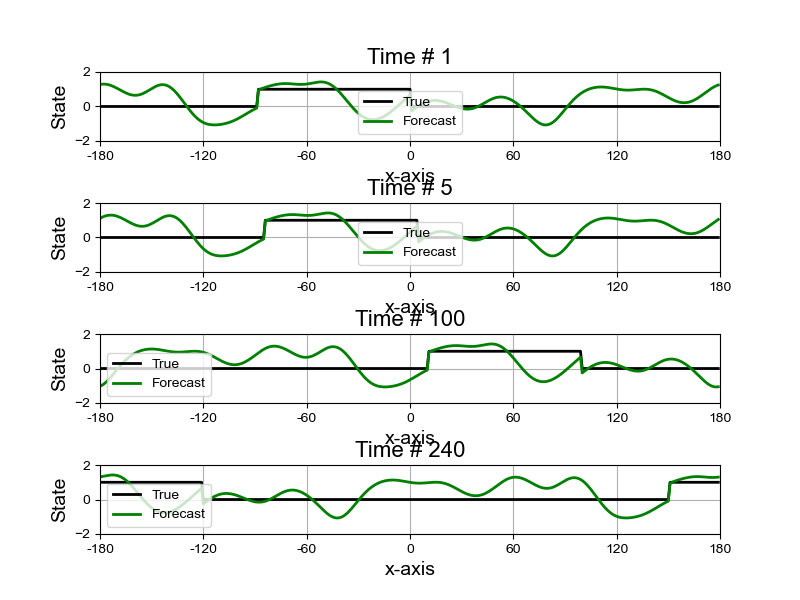

In [54]:
fig = plt.figure(figsize=(8, 6))

# Loop through different times
for idx, time in enumerate([1, 5, 100, 240], start=1):
    plt.subplot(4, 1, idx)
    plt.plot(x, xt_save[:, time - 1], 'k-', linewidth=2, label='True')
    plt.plot(x, xf_save[:, time - 1], color=[0, 0.5, 0], linewidth=2, label='Forecast')
    plt.xlabel('x-axis', fontsize=14)
    plt.ylabel('State', fontsize=14)
    plt.title('Time # ' + str(time), fontsize=16)
    plt.xlim([La, Lb])
    plt.ylim([-2, 2])
    plt.xticks(np.arange(La, Lb + 60, 60), ['-180', '-120', '-60', '0', '60', '120', '180'])
    plt.grid(True)
    plt.legend()

fig.subplots_adjust(hspace=0.9)
